In [1]:
%matplotlib nbagg

Height map
==========

/home/valls/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


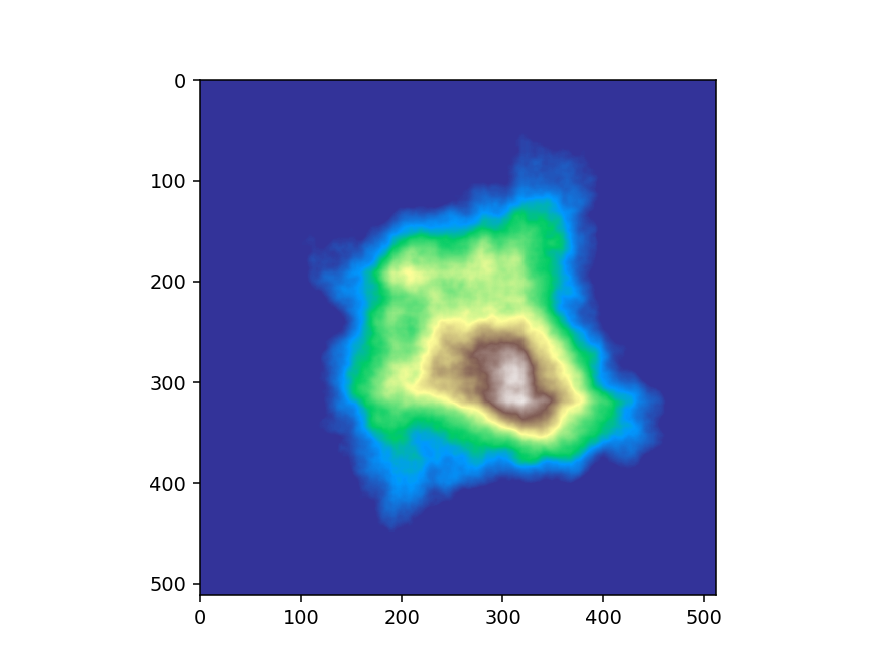

In [248]:
import skimage.transform
import skimage.filters
import numpy

def create_value_noise(shape, octaves=8, weights=None, first_array=None):
    data = numpy.zeros(shape, dtype=numpy.float32)
    t = 2
    for i in range(octaves):
        if t > shape[0] and t > shape[1]:
            break
        if i == 0 and first_array is not None:
            d = first_array
        else:
            if weights is None:
                w = (256 >> i) - 1
            else:
                w = weights[i]
            d = numpy.random.randint(w, size=(t, t), dtype=numpy.uint8)
        d = skimage.transform.resize(d, shape)
        data = data + d
        t = t << 1
    return data

def create_island(shape, summit, under_water):
    # Force a centric shape
    first_array = numpy.zeros((4, 4), dtype=numpy.uint8)
    first_array[1:3,1:3] = 255
    weights = [255] + [(256 >> (i)) - 1 for i in range(8)]
    data = create_value_noise(shape, octaves=7, first_array=first_array, weights=weights)
    # more slops
    data *= data
    # normalize the height
    data -= data.min()
    data = data * ((summit + under_water) / data.max()) - under_water
    return data

from matplotlib import pyplot
colormap = pyplot.cm.terrain
data = create_island((512, 512), summit=4808.72, under_water=1500)
pyplot.figure()
pyplot.imshow(data, cmap=colormap, vmin=0, vmax=5000)
pyplot.show()

Rescale without skimage
=======================

<IPython.core.display.Javascript object>


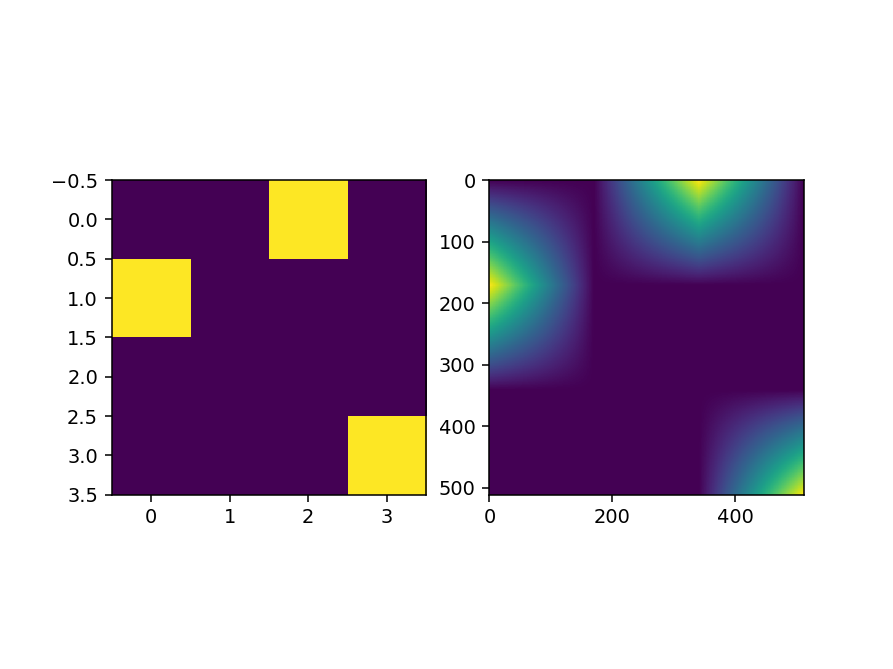

In [123]:
import silx.image.bilinear

def rescale_image(image, shape):
    y, x = numpy.ogrid[:shape[0], :shape[1]]
    y, x = y * 1.0 * (image.shape[0] - 1) / (shape[0] - 1), x * 1.0 * (image.shape[1] - 1) / (shape[1] - 1)
    b = silx.image.bilinear.BilinearImage(image)
    x2d = numpy.zeros_like(y) + x
    y2d = numpy.zeros_like(x) + y
    result = b.map_coordinates((y2d, x2d))
    return result

image = numpy.zeros((4, 4), dtype=numpy.float32)
image[3,3] = 255
image[1,0] = 255
image[0,2] = 255
result = rescale_image(image, (512, 512))

from matplotlib import pyplot
pyplot.figure()
pyplot.subplot("121")
pyplot.imshow(image)
pyplot.subplot("122")
pyplot.imshow(result)
pyplot.show()

Height map without skimage
==========================

In [261]:
import numpy
import silx.image.bilinear


def rescale_image(image, shape):
    y, x = numpy.ogrid[:shape[0], :shape[1]]
    y, x = y * 1.0 * image.shape[0] / shape[0], x * 1.0 * image.shape[1] / shape[1]
    b = silx.image.bilinear.BilinearImage(image)
    # TODO: could be optimized using strides
    x2d = numpy.zeros_like(y) + x
    y2d = numpy.zeros_like(x) + y
    result = b.map_coordinates((y2d, x2d))
    return result

def create_value_noise(shape, octaves=8, weights=None, first_array=None):
    data = numpy.zeros(shape, dtype=numpy.float32)
    t = 2
    for i in range(octaves):
        if t > shape[0] and t > shape[1]:
            break
        if i == 0 and first_array is not None:
            d = first_array
        else:
            if weights is None:
                w = (256 >> i) - 1
            else:
                w = weights[i]
            d = numpy.random.randint(w, size=(t, t), dtype=numpy.uint8)
        d = rescale_image(d, shape)
        data = data + d
        t = t << 1
    return data

def create_island(shape, summit, under_water):
    # Force a centric shape
    first_array = numpy.zeros((4, 4), dtype=numpy.uint8)
    first_array[1:3,1:3] = 255
    weights = [255] + [(256 >> (i)) - 1 for i in range(8)]
    data = create_value_noise(shape, octaves=7, first_array=first_array, weights=weights)
    # more slops
    data *= data
    # normalize the height
    data -= data.min()
    data = data * ((summit + under_water) / data.max()) - under_water
    return data

<IPython.core.display.Javascript object>


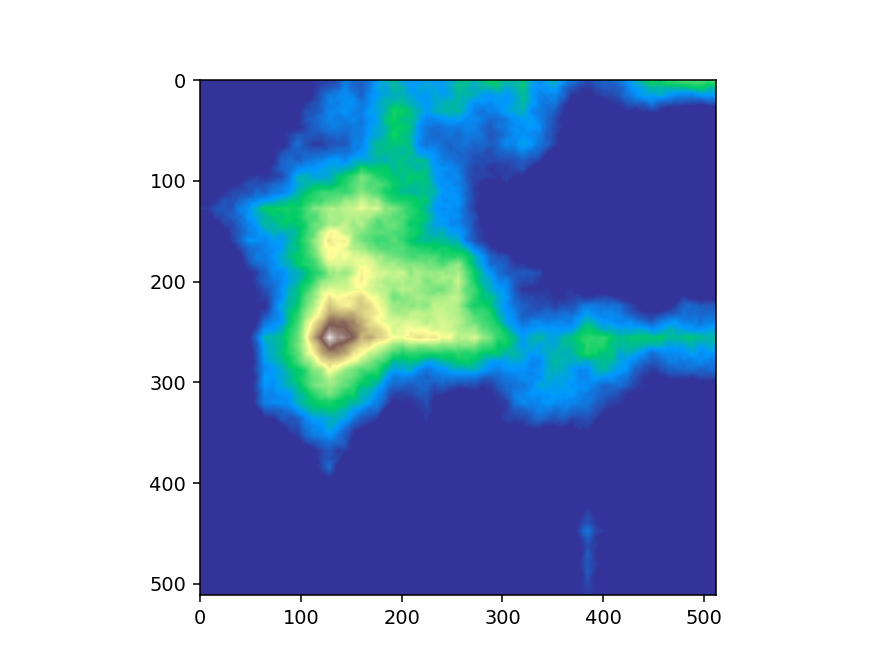

In [262]:
from matplotlib import pyplot
colormap = pyplot.cm.terrain
data = create_island((512, 512), summit=4808.72, under_water=1500)
pyplot.figure()
pyplot.imshow(data, cmap=colormap, vmin=0, vmax=5000)
pyplot.show()

In [4]:
from impl.MarchingSquareSciKitImage import MarchingSquareSciKitImage

/home/valls/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


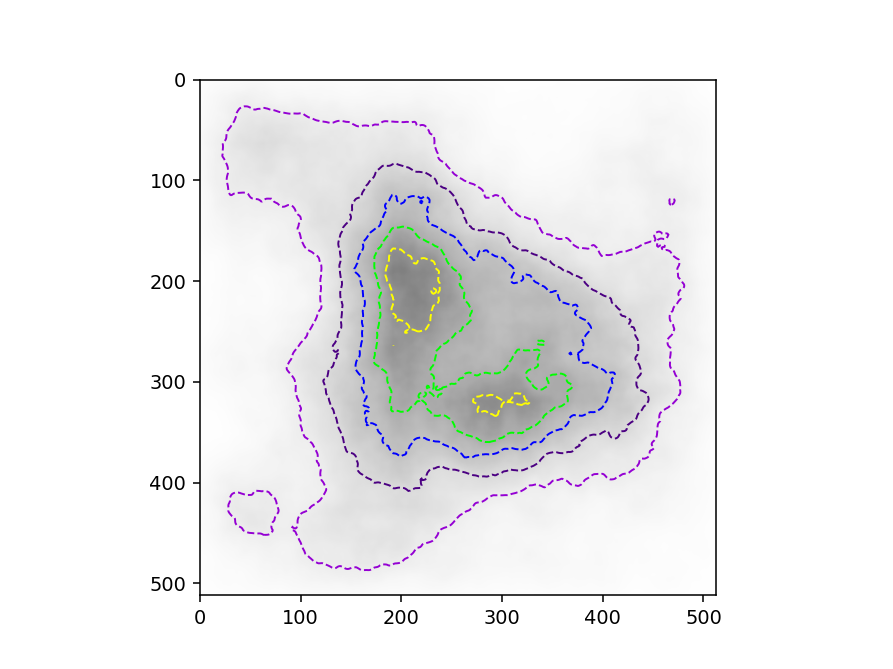

In [5]:
def show_map(heigth_map, marching_square):
    from matplotlib import pyplot
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection

    pyplot.figure()
    ax = pyplot.gca()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, heigth_map.shape[0]])
    ax.set_xlim([0, heigth_map.shape[1]])
    ax.invert_yaxis()

    values =[0, 1000, 2000, 3000, 4000]

    # image
    pyplot.imshow(heigth_map, cmap="Greys", alpha=.5)

    # iso contours
    colors = ["#9400D3", "#4B0082", "#0000FF", "#00FF00", "#FFFF00", "#FF7F00", "#FF0000"]
    for ivalue, value in enumerate(values):
        color = colors[ivalue % len(colors)]
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            if len(p) == 0:
                continue
            is_closed = numpy.allclose(p[0], p[-1])
            p = Polygon(p, fill=False, edgecolor=color, closed=is_closed, linestyle="--")
            ax.add_patch(p)

    pyplot.show()


heigth_map = create_island((512, 512), summit=4808.72, under_water=1500)
algo = MarchingSquareSciKitImage(heigth_map)
show_map(heigth_map, algo)

/home/valls/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<IPython.core.display.Javascript object>


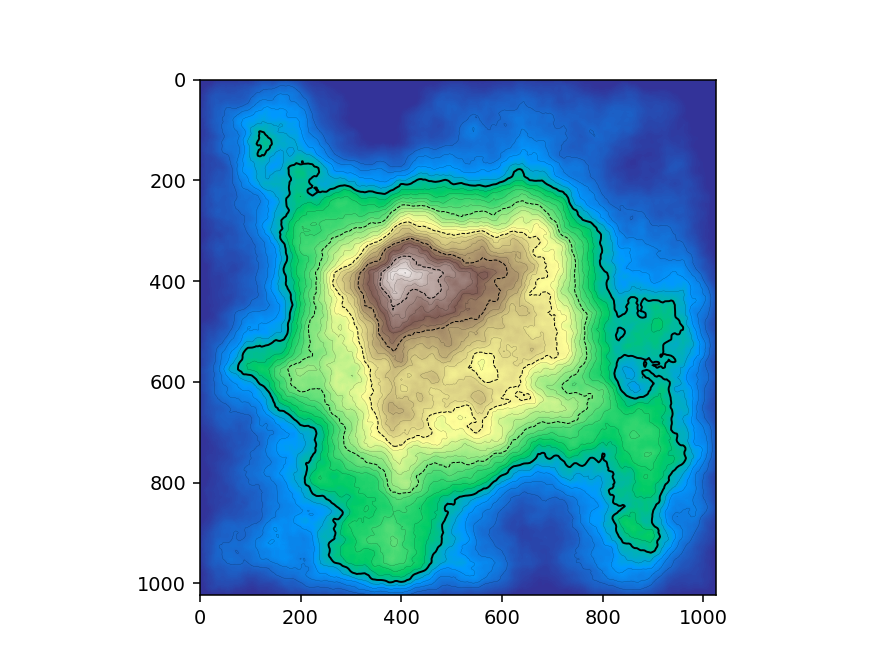

In [6]:
def show_map(heigth_map, marching_square):
    from matplotlib import pyplot
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection

    pyplot.figure()
    ax = pyplot.gca()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, heigth_map.shape[0]])
    ax.set_xlim([0, heigth_map.shape[1]])
    ax.invert_yaxis()

    #values =[0, 1000, 2000, 3000, 4000]
    values = range(-800, 5000, 200)

    colormap = pyplot.cm.terrain
    # colormap = pyplot.cm.gist_earth

    # image
    pyplot.imshow(heigth_map, cmap=colormap, vmin=-1300, vmax=5000)

    # iso contours
    for ivalue, value in enumerate(values):
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            if len(p) == 0:
                continue
            if value == 0:
                extra_style = {"linestyle": "-", "linewidth": 1.0}
            elif value % 1000 == 0:
                extra_style = {"linestyle": "--", "linewidth": 0.5}
            else:
                extra_style = {"linestyle": "--", "linewidth": 0.1}
            is_closed = numpy.allclose(p[0], p[-1])
            p = Polygon(p, fill=False, edgecolor="black", closed=is_closed, **extra_style)
            ax.add_patch(p)

    pyplot.show()


shape = (1024, 1024)
heigth_map = create_island(shape, summit=4808.72, under_water=1500)
algo = MarchingSquareSciKitImage(heigth_map)
show_map(heigth_map, algo)

Rings
=====

<IPython.core.display.Javascript object>


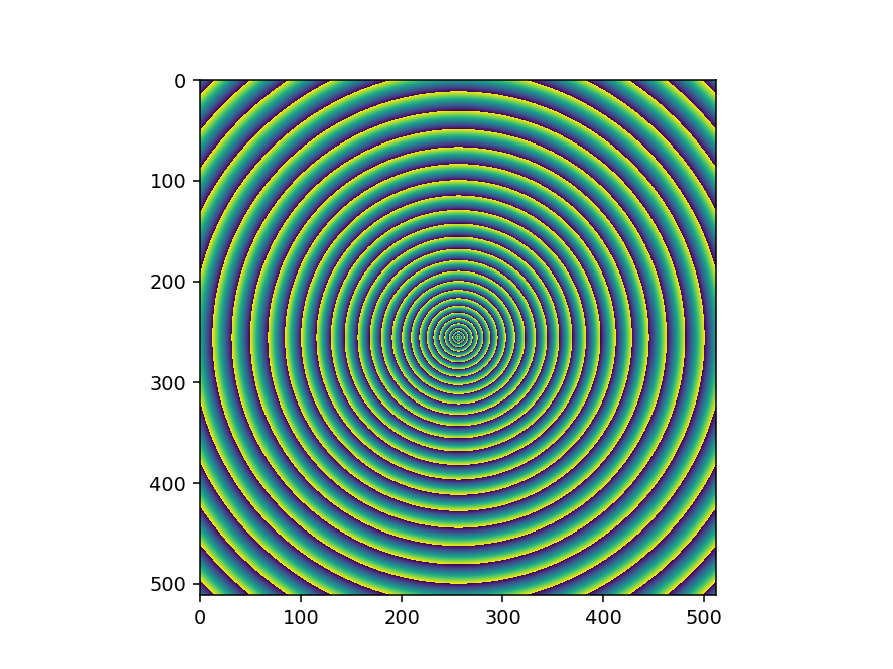

In [7]:
def create_circles(size, dx=0, dy=0, freq=100, sx=1.0, sy=1.0):
    half = size // 2
    yy, xx = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    yy, xx = (yy - (dy * half)) * coef, (xx - (dx * half)) * coef + 0.0001
    distance = numpy.sqrt(numpy.sqrt(xx*xx * sx + yy*yy * sy))
    data = numpy.fmod(distance * freq * half / 100, 1, dtype=numpy.float32)
    return data

from matplotlib import pyplot
pyplot.figure()
pyplot.imshow(create_circles(512, dx=0.0, dy=0.0, freq=10, sx=1))
pyplot.show()


Magnetic field
==============

In [95]:
def create_magnetic_field(size, x1=0.0, y1=0.0, x2=0.0, y2=0.0):
    half = size // 2
    yy, xx = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    yy1, xx1 = (yy + half * y1) * coef, (xx  + half * x1) * coef
    distance1 = numpy.sqrt(xx1 * xx1 + yy1 * yy1)
    yy2, xx2 = (yy + half * y2) * coef, (xx  + half * x2) * coef
    distance2 = numpy.sqrt(xx2 * xx2 + yy2 * yy2)

    return (numpy.arctan2(distance1, distance2) - numpy.pi * 0.25) * 1000

In [190]:
def show_magnetic(heigth_map, marching_square):
    from matplotlib import pyplot
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection

    pyplot.figure()
    ax = pyplot.gca()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, heigth_map.shape[0]])
    ax.set_xlim([0, heigth_map.shape[1]])
    ax.invert_yaxis()


    colormap = pyplot.cm.coolwarm
    #colormap = pyplot.cm.cool
    # colormap = pyplot.cm.bw

    # image
    maximum = abs(image.max())
    m = abs(image.min())
    if m > maximum:
        maximum = m
    maximum = int(maximum)

    values = range(-maximum, maximum, maximum // 20)

    pyplot.imshow(heigth_map, cmap=colormap, vmin=-maximum, vmax=maximum)

    # iso contours
    for ivalue, value in enumerate(values):
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            if len(p) == 0:
                continue
            if (ivalue % 2) == 0:
                extra_style = {"linestyle": "-", "linewidth": 0.5, "edgecolor": "black"}
            else:
                extra_style = {"linestyle": "-", "linewidth": 0.5, "edgecolor": "white"}
            is_closed = numpy.allclose(p[0], p[-1])
            p = Polygon(p, fill=False, closed=is_closed, **extra_style)
            ax.add_patch(p)

    pyplot.show()

<IPython.core.display.Javascript object>


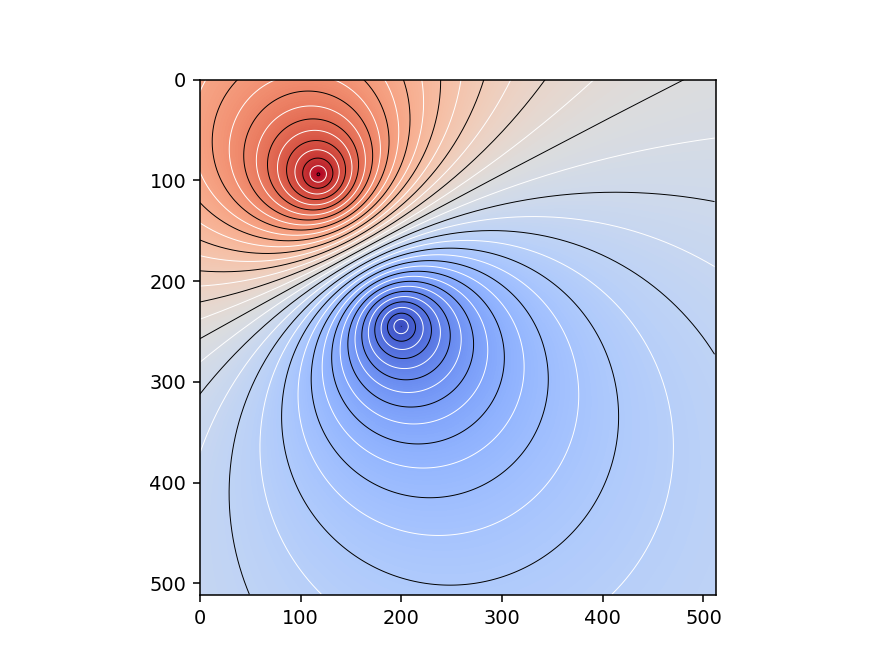

In [195]:
shape = 512
x1 = numpy.random.random() * 2 - 1
y1 = numpy.random.random() * 2 - 1
x2 = numpy.random.random() * 2 - 1
y2 = numpy.random.random() * 2 - 1
image = create_magnetic_field(512, x1, y1, x2, y2)
algo = MarchingSquareSciKitImage(image)
show_magnetic(image, algo)

Gravity field
=============

In [138]:
def create_gravity_field(size, objects):
    half = size // 2
    yy, xx = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    def distance(x, y):
        yy1, xx1 = (yy + half * y) * coef, (xx  + half * x) * coef
        return numpy.sqrt(xx1 ** 2 + yy1 ** 2)
    result = numpy.zeros((size, size), dtype=numpy.float32)
    for x, y, m in objects:
        result += m / distance(x, y)
    return  numpy.log(result) * 1000

In [168]:
def show_gravity(heigth_map, marching_square):
    from matplotlib import pyplot
    import matplotlib
    from matplotlib.patches import Polygon
    from matplotlib.collections import PatchCollection

    pyplot.figure()
    ax = pyplot.gca()
    ax.set_xmargin(0.1)
    ax.set_ymargin(0.1)
    ax.set_ylim([0, heigth_map.shape[0]])
    ax.set_xlim([0, heigth_map.shape[1]])
    ax.invert_yaxis()


    colormap = pyplot.cm.inferno

    # image
    delta = int((image.max() - image.min()) // 30)
    values = range(int(image.min()), int(image.max()), delta)

    pyplot.imshow(heigth_map, cmap=colormap)

    # iso contours
    for ivalue, value in enumerate(values):
        polygons = marching_square.iso_contour(value)
        for p in polygons:
            if len(p) == 0:
                continue
            extra_style = {"linestyle": "-", "linewidth": 0.1}
            is_closed = numpy.allclose(p[0], p[-1])
            p = Polygon(p, fill=False, edgecolor="white", closed=is_closed, **extra_style)
            ax.add_patch(p)

    pyplot.show()

<IPython.core.display.Javascript object>


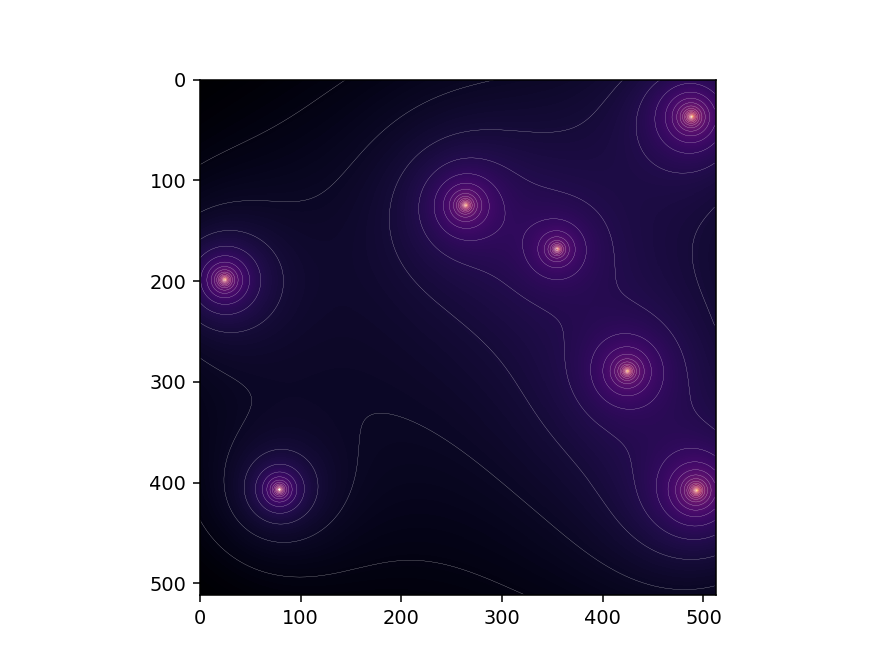

In [169]:
shape = 512
nb = numpy.random.randint(2, 10)
objects = []
for i in range(nb):
    x = numpy.random.random() * 2 - 1
    y = numpy.random.random() * 2 - 1
    m = numpy.random.random() * 10 + 1.0
    objects.append((x, y, m))
image = create_gravity_field(shape, objects)

algo = MarchingSquareSciKitImage(image)
show_gravity(image, algo)

Composite gradient
==================

In [101]:
import numpy

def create_gradient(size, dx=0, dy=0, sx=1.0, sy=1.0):
    half = size // 2
    yy, xx = numpy.ogrid[-half:half, -half:half]
    coef = 1 / half
    yy, xx = (yy - (dy * half)) * coef, (xx - (dx * half)) * coef + 0.0001
    distance = numpy.sqrt(xx * xx * sx + yy * yy * sy)
    return distance


def create_composite_gradient(size, dx=0, dy=0, sx=1.0, sy=1.0):
    hole = (size - 4) // 4
    gap = 10
    base = create_gradient(size + hole + gap * 4, dx, dy, sx, sy)
    result = numpy.zeros((size, size))
    width = (size - 2) // 2
    half_hole = hole // 2

    def copy_module(x1, y1, x2, y2, width, height):
        result[y1:y1 + height, x1:x1 + width] = base[y2:y2 + height, x2:x2 + width]

    y1 = 0
    y2 = 0
    copy_module(0, y1, half_hole, y2, width, hole)
    copy_module(width + 1, y1, half_hole + width, y2, width, hole)

    y1 += hole + 1
    y2 += hole + gap
    copy_module(0, y1, 0, y2, width, hole)
    copy_module(width + 1, y1, width + hole, y2, width, hole)

    y1 += hole + 1
    y2 += hole + gap
    copy_module(0, y1, half_hole, y2, width, hole)
    copy_module(width + 1, y1, half_hole + width, y2, width, hole)

    y1 += hole + 1
    y2 += hole + gap
    copy_module(0, y1, half_hole, y2, width, hole)
    copy_module(width + 1, y1, half_hole + width, y2, width, hole)

    return result

<IPython.core.display.Javascript object>


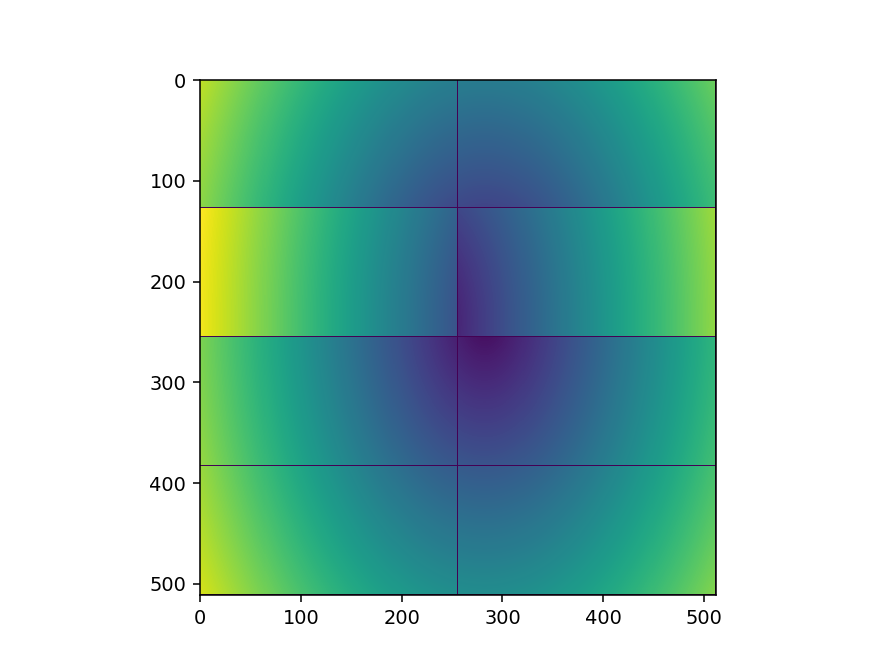

In [120]:
size = 512
hole = 1 / 4.0
dx = numpy.random.random() * hole - hole / 2.0
dy = numpy.random.random() * hole - hole- hole
sx = numpy.random.random() * 10.0 + 1
sy = numpy.random.random() * 10.0 + 1
image = create_composite_gradient(size, dx, dy, sx, sy)

from matplotlib import pyplot
pyplot.figure()
pyplot.imshow(image)
pyplot.show()

In [124]:
numpy.arange(10,20,0.5
            )

array([10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
       15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5])

<IPython.core.display.Javascript object>


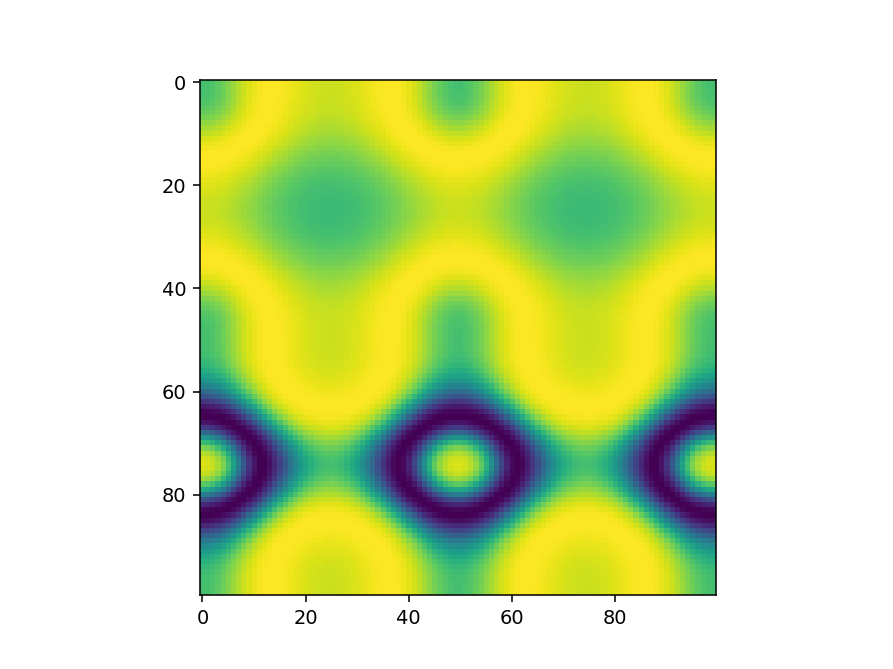

In [15]:
# The one used in skimage find_contours example
import numpy
x, y = numpy.ogrid[-numpy.pi:numpy.pi:100j, -numpy.pi:numpy.pi:100j]
image = numpy.sin(numpy.exp((numpy.sin(x)**3 + numpy.cos(y)**2)))

from matplotlib import pyplot
pyplot.figure()
pyplot.imshow(image)
pyplot.show()